In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
pd.options.display.max_columns=1000
pd.options.display.max_rows=10

In [2]:
app_train = pd.read_csv('C://Users/matth/home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).sample(n=70000,random_state=42)
app_test = pd.read_csv('C://Users/matth/home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True)

In [3]:
app_train["TARGET"].value_counts()

0    64364
1     5636
Name: TARGET, dtype: int64

In [4]:
app_train_0=app_train[app_train['TARGET']==0]
app_train_1=app_train[app_train['TARGET']==1]
app_train_0=app_train_0.sample(n=5000,replace=False,random_state=42)
app_train_1=app_train_1.sample(n=5000,replace=False,random_state=42)
app_train=app_train_1.append(app_train_0,ignore_index=True)
app_train=app_train.sample(frac=1,random_state=42).reset_index(drop=True)

In [5]:
app=app_train.append(app_test,ignore_index=True)
app=app.drop("SK_ID_CURR",axis=1)
len(app[app["TARGET"]==0]),len(app[app["TARGET"]==1])

(5000, 5000)

In [6]:
categorical_features=app.select_dtypes(include="object").columns
unique_values=[len(app[x].unique()) for x in categorical_features]
print(f'Using pd get_dummies for all categorical features will lead to {sum(unique_values)} new features')

Using pd get_dummies for all categorical features will lead to 144 new features


In [7]:
get_dummies=pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[8:]
print(f'Using pd get_dummies for the simplest 8 features will lead to {get_dummies["Number of unique"].sum()} new features')

Using pd get_dummies for the simplest 8 features will lead to 25 new features


In [8]:
pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[:8]

,Number of unique
ORGANIZATION_TYPE,58
OCCUPATION_TYPE,19
NAME_TYPE_SUITE,8
NAME_INCOME_TYPE,8
WALLSMATERIAL_MODE,8
WEEKDAY_APPR_PROCESS_START,7
NAME_HOUSING_TYPE,6
NAME_EDUCATION_TYPE,5


In [9]:
label_encoding=pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[:8].index

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for c in label_encoding:
    le.fit(list(app[c].values))
    app[c]=le.transform(list(app[c].values))

In [11]:
app=pd.get_dummies(app,drop_first=True)

In [12]:
correlations=app.corr()["TARGET"]

In [13]:
correlations=pd.DataFrame(correlations)
correlations["TARGET abs"]=abs(correlations["TARGET"])

In [14]:
correlations=correlations.sort_values(by="TARGET abs",ascending=False)

In [15]:
relevant_features=correlations.index[1:16]
relevant_features

Index(['EXT_SOURCE_3', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_BIRTH',
       'NAME_EDUCATION_TYPE', 'CODE_GENDER_M', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_RATING_CLIENT', 'FLAG_EMP_PHONE', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'FLOORSMAX_MEDI', 'FLOORSMAX_AVG',
       'FLOORSMAX_MODE'],
      dtype='object')

In [16]:
missing_data=[app[x].isna().sum()/len(app[x]) for x in relevant_features if app[x].isna().sum()!=0]
missing_cols=[x for x in relevant_features if app[x].isna().sum()!=0]
missing_data=pd.DataFrame(data=missing_data,index=missing_cols,columns=["% of missing data"])
missing_data=missing_data.sort_values(by="% of missing data",ascending=False)
missing_data

,% of missing data
OWN_CAR_AGE,0.665753
FLOORSMAX_MEDI,0.486313
FLOORSMAX_AVG,0.486313
FLOORSMAX_MODE,0.486313
EXT_SOURCE_1,0.448012
EXT_SOURCE_3,0.182555
EXT_SOURCE_2,0.000477


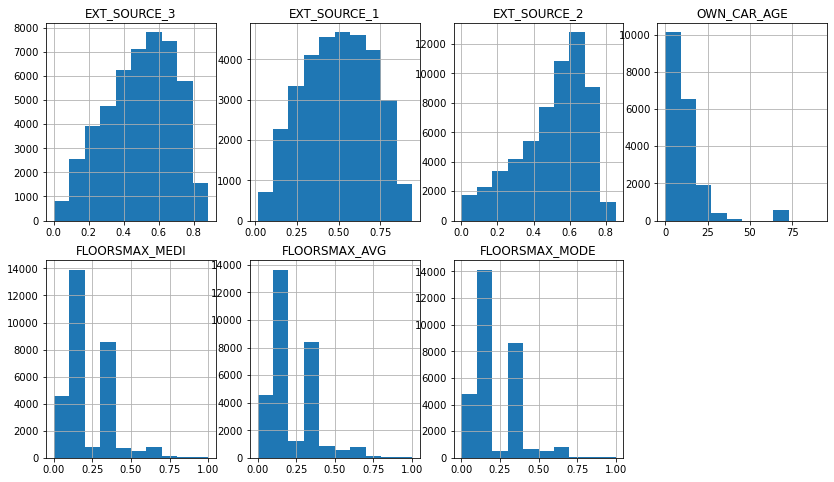

In [17]:
plt.figure(figsize=(14,8))
count=1
for x in missing_cols:
    plt.subplot(2,4,count)
    app[x].hist()
    plt.title(x)
    count+=1

In [18]:
#ext1_corr=app.corr()["EXT_SOURCE_1"]

In [19]:
#abs(pd.DataFrame(ext1_corr)).sort_values(by="EXT_SOURCE_1", ascending=False)

In [20]:
#missing_ext1_rows= app[app["EXT_SOURCE_1"].isna()].index

In [21]:
#This takes 100 years
#for x in missing_ext1_rows:
#    app.loc[x,"EXT_SOURCE_1"]=app[(app["DAYS_BIRTH"]==app.loc[x,"DAYS_BIRTH"]) & (app["CODE_GENDER_M"]==app.loc[x,"CODE_GENDER_M"])]\
#    ["EXT_SOURCE_1"].median()

In [22]:
#app["EXT_SOURCE_1"].fillna(app["EXT_SOURCE_1"].median(),inplace=True)

In [23]:
#ext2_corr=app.corr()["EXT_SOURCE_2"]

In [24]:
#abs(pd.DataFrame(ext2_corr)).sort_values(by="EXT_SOURCE_2", ascending=False)

In [25]:
#missing_ext2_rows= app[app["EXT_SOURCE_2"].isna()].index

In [26]:
#This takes 100 years
#for x in missing_ext2_rows:
#    app.loc[x,"EXT_SOURCE_2"]=app[(app["REGION_RATING_CLIENT"]==app.loc[x,"REGION_RATING_CLIENT"]) & (app["REGION_RATING_CLIENT_W_CITY"]==app.loc[x,"REGION_RATING_CLIENT_W_CITY"])]\
#    ["EXT_SOURCE_2"].median()

In [27]:
missing_cols=[x for x in relevant_features if app[x].isna().sum()!=0]
for x in missing_cols:
    app[x].fillna(app[x].median(),inplace=True)

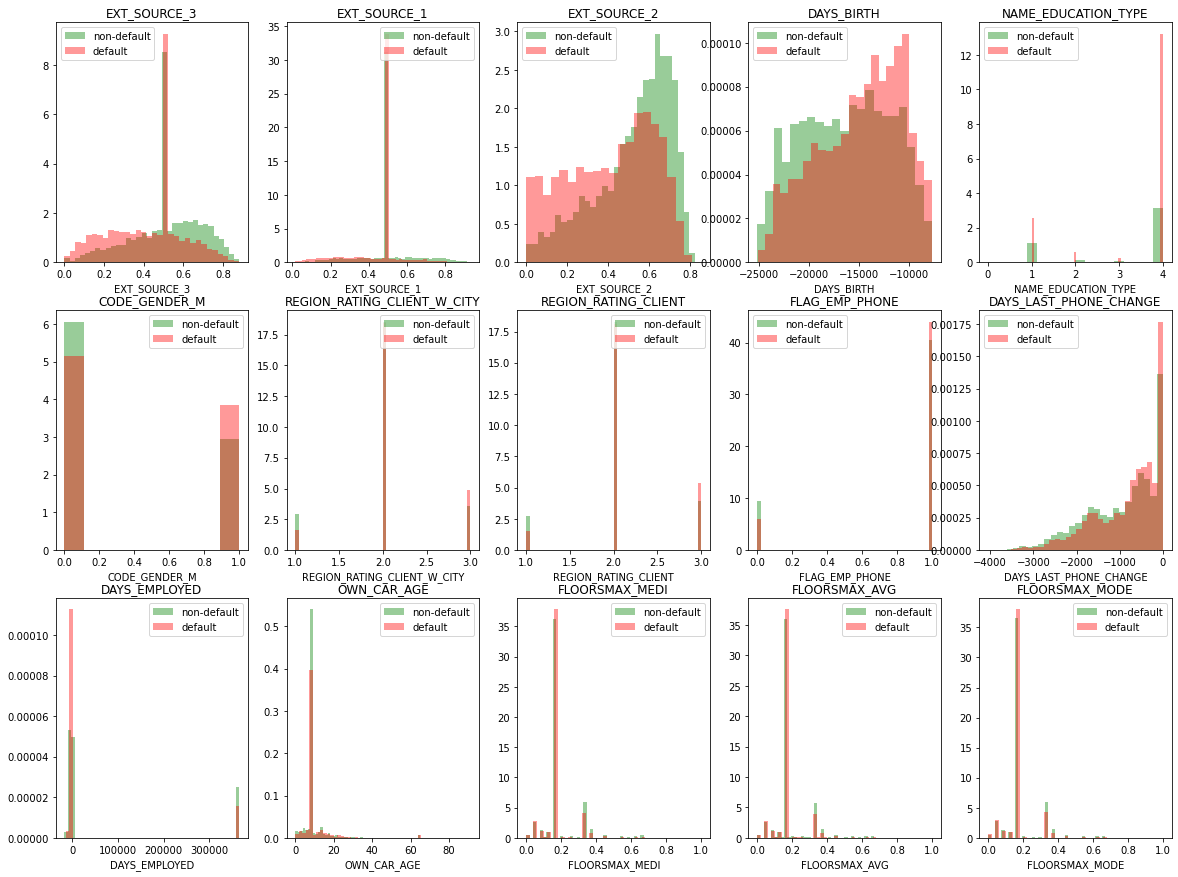

In [28]:
plt.figure(figsize=(20,15))
counter=1
for x in relevant_features:
    plt.subplot(3,5,counter)
    sns.distplot(app[app["TARGET"]==0][x],color="g",label="non-default",kde=False,norm_hist=True)
    sns.distplot(app[app["TARGET"]==1][x],color="r",label="default",kde=False,norm_hist=True)
    plt.legend()
    plt.title(x)
    counter+=1

In [35]:
app["EXT_SOURCE_COMBINED"]=app['EXT_SOURCE_1']+app['EXT_SOURCE_2']+app['EXT_SOURCE_3'""]
app.corr()["TARGET"]["EXT_SOURCE_COMBINED"]

-0.37429633361112397

In [70]:
#Assume everyone with outlier days employed is employed long enough
outlier_index=app[app["DAYS_EMPLOYED"]>15000].index
app.loc[outlier_index,"DAYS_EMPLOYED"]=0

In [75]:
app["DAYS_EMPLOYED"]=app["DAYS_EMPLOYED"]-app["DAYS_EMPLOYED"].min()

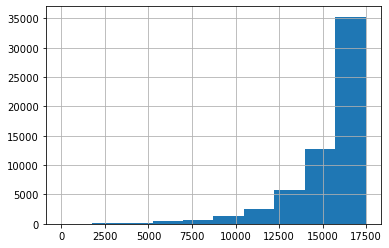

In [76]:
app["DAYS_EMPLOYED"].hist()

In [88]:
app["DAYS_LAST_PHONE_CHANGE"]=app["DAYS_LAST_PHONE_CHANGE"]-app["DAYS_LAST_PHONE_CHANGE"].min()

In [77]:
correlations=app.corr()["TARGET"]

In [78]:
correlations=pd.DataFrame(correlations)
correlations["TARGET abs"]=abs(correlations["TARGET"])

In [79]:
correlations=correlations.sort_values(by="TARGET abs",ascending=False)

In [81]:
relevant_features=correlations.index[1:16]
relevant_features

Index(['EXT_SOURCE_COMBINED', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1',
       'DAYS_BIRTH', 'NAME_EDUCATION_TYPE', 'CODE_GENDER_M',
       'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'FLAG_EMP_PHONE',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED', 'NAME_INCOME_TYPE',
       'FLAG_DOCUMENT_3', 'DAYS_ID_PUBLISH'],
      dtype='object')

In [89]:
ntrain=app["TARGET"].notna().sum()
y=app["TARGET"][:ntrain]
X=app[relevant_features][:ntrain]
X_final=app[relevant_features][ntrain:]

In [90]:
#Poly transformation not useful
#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(2)
#poly_features=poly.fit_transform(X)
#poly_features.shape,X.shape

In [91]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

(<matplotlib.axes._subplots.AxesSubplot at 0x22a608534c8>,
 Text(0.5, 1.0, 'Kbest scores'))

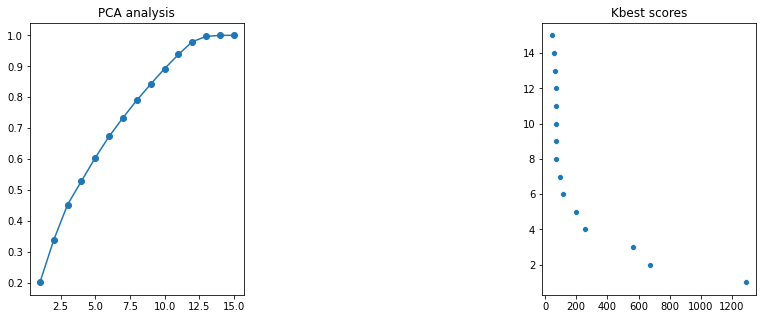

In [92]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
pca=PCA()
pca.fit(X_train)
plt.figure(figsize=(13,5))
components=range(1,len(pca.explained_variance_ratio_)+1)
plt.subplot(1,3,1)
plt.plot(components,pca.explained_variance_ratio_.cumsum(),marker='o'),plt.title("PCA analysis")
kbest=SelectKBest(k="all")
kbest.fit(X_train,y_train)
plt.subplot(1,3,3)
sns.scatterplot(kbest.scores_,components),plt.title("Kbest scores")
#I will use all relevant features for now

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

test_range=range(6,15)
lr=LogisticRegression(max_iter=500)
feature_scoring=pd.DataFrame(columns=["kbest score","pca score"],index=test_range)

for i in test_range:
    kbest=SelectKBest(k=i)
    pca=PCA(n_components=i)
    X_train_kbest=kbest.fit_transform(X_train,y_train)
    X_train_pca=pca.fit_transform(X_train)
    X_test_kbest=kbest.transform(X_test)
    X_test_pca=pca.transform(X_test)
    
    kbest_train=lr.fit(X_train_kbest,y_train)
    kbest_score=lr.predict_proba(X_test_kbest)[:,1]
    feature_scoring.loc[i,'kbest score']=roc_auc_score(y_test,kbest_score)
    
    pca_train=lr.fit(X_train_pca,y_train)
    pca_score=lr.predict_proba(X_test_pca)[:,1]
    feature_scoring.loc[i,'pca score']=roc_auc_score(y_test,kbest_score)
feature_scoring.sort_values(by="pca score", ascending=False,inplace=True)
feature_scoring

,kbest score,pca score
14,0.738562,0.738562
13,0.735669,0.735669
12,0.735542,0.735542
10,0.735522,0.735522
11,0.735202,0.735202
9,0.731069,0.731069
8,0.729901,0.729901
7,0.729295,0.729295
6,0.727368,0.727368


In [94]:
best_features=feature_scoring.index[0]
pca=PCA(n_components=best_features)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)
#X_train_pca=kbest.fit_transform(X_train,y_train)
#X_test_pca=kbest.transform(X_test)

In [95]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

lr=LogisticRegression()
svc=SVC(probability=True)
knn=KNeighborsClassifier()
dtr=DecisionTreeClassifier()
rfc=RandomForestClassifier()

models={"Logistic regression":lr,"Support vector classifier": svc,"K neighbours classifier":knn, \
       "Decision tree classifier": dtr, "Random forest classifier": rfc}

In [96]:
#Untuned model predictions and score
base_model_scores=pd.DataFrame(index=models.keys(),columns=[["training score","ROC AUC"]])
t0=time.time()
for key,model in models.items():
    model.fit(X_train_pca,y_train)
    train_score=cross_val_score(model,X_train_pca,y_train)
    pred=model.predict_proba(X_test_pca)[:,1]
    roc=roc_auc_score(y_test,pred)
    base_model_scores.loc[key,"training score"]=train_score.mean()
    base_model_scores.loc[key,"ROC AUC"]=roc
    print(time.time()-t0)
base_model_scores

0.0638270378112793
41.62834978103638
42.594422340393066
43.12089514732361
51.16281318664551


,training score,ROC AUC
Logistic regression,0.6705,0.739063
Support vector classifier,0.665625,0.727536
K neighbours classifier,0.618375,0.665466
Decision tree classifier,0.578,0.580345
Random forest classifier,0.645875,0.719598


In [97]:
#Untuned model average predictions
p1=lr.predict_proba(X_test_pca)[:,1]
p2=svc.predict_proba(X_test_pca)[:,1]
p3=knn.predict_proba(X_test_pca)[:,1]
p4=dtr.predict_proba(X_test_pca)[:,1]
p5=rfc.predict_proba(X_test_pca)[:,1]

p_ave=(p1+p5)/2
roc_auc_score(y_test,p_ave)

0.7379177080926677

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

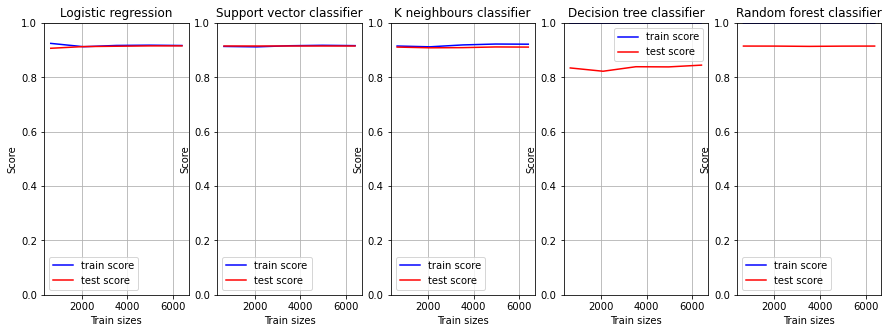

In [37]:
#from sklearn.model_selection import learning_curve
#x=1
#plt.figure(figsize=(15,5))
#for key, model in models.items():
#    train_sizes, train_scores, test_scores=learning_curve(model,X_train_pca,y_train)
#    plt.subplot(1,5,x)
#    plt.plot(train_sizes,train_scores.mean(axis=1),color="b",label="train score")
#    plt.plot(train_sizes,test_scores.mean(axis=1),color="r",label="test score")
#    plt.xlabel("Train sizes"),plt.ylabel("Score"),plt.grid(True),plt.legend(loc="best"),plt.ylim((0,1)),plt.title(key)

#    x=x+1

In [98]:
def objective(model,hyperparameters,iteration):
    cv_results=cross_val_score(model,X_train_pca,y_train).mean()
    model.fit(X_train_pca,y_train)
    pred=model.predict_proba(X_test_pca)[:,1]
    roc=roc_auc_score(y_test,pred)
    
    return (cv_results,roc,hyperparameters)

In [99]:
lr_param_grid={"penalty": ['l1','l2','elasticnet','none'],
           "C": [0.001,0.01,0.1,1,10,100],
           "dual": [True,False],
            "fit_intercept": [True,False],
            "solver": ['lbfgs', 'sag', 'saga'],
            "max_iter": [int(x) for x in np.linspace(start=100,stop=300,num=10)]}

rfc_param_grid={"n_estimators":[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                "criterion": ['gini','entropy'],
                "max_features":["auto", "sqrt", "log2"],
                "bootstrap": [True,False]}

svc_param_grid={"C":[0.01,0.1,1,10,100],
                "kernel":['linear', 'poly', 'rbf', 'sigmoid'],
                "gamma":['scale','auto'],
                "shrinking":[True,False],
                "probability":[True]}


In [100]:
#This displaces the weird random_grid_search function
from sklearn.model_selection import RandomizedSearchCV
lr_random=RandomizedSearchCV(estimator=lr,param_distributions=lr_param_grid,n_iter=10,cv=3,verbose=2)
lr_random.fit(X_train_pca,y_train)
lr_random.best_params_,lr_random.best_score_,lr_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] solver=sag, penalty=none, max_iter=188, fit_intercept=True, dual=True, C=1 
[CV]  solver=sag, penalty=none, max_iter=188, fit_intercept=True, dual=True, C=1, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=188, fit_intercept=True, dual=True, C=1 
[CV]  solver=sag, penalty=none, max_iter=188, fit_intercept=True, dual=True, C=1, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=188, fit_intercept=True, dual=True, C=1 
[CV]  solver=sag, penalty=none, max_iter=188, fit_intercept=True, dual=True, C=1, total=   0.0s
[CV] solver=saga, penalty=l2, max_iter=122, fit_intercept=False, dual=False, C=0.1 
[CV]  solver=saga, penalty=l2, max_iter=122, fit_intercept=False, dual=False, C=0.1, total=   0.0s
[CV] solver=saga, penalty=l2, max_iter=122, fit_intercept=False, dual=False, C=0.1 
[CV]  solver=saga, penalty=l2, max_iter=122, fit_intercept=False, dual=False, C=0.1, total=   0.0s
[CV] solver=saga, penalty=l2, max_iter=122

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 446, in _check_solver
    "dual=False, got dual=%s" % (solver, dual))
ValueError: Solver sag supports only dual=False, got dual=True

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 ou

[CV]  solver=saga, penalty=l1, max_iter=211, fit_intercept=False, dual=False, C=0.01, total=   0.0s
[CV] solver=saga, penalty=l1, max_iter=211, fit_intercept=False, dual=False, C=0.01 
[CV]  solver=saga, penalty=l1, max_iter=211, fit_intercept=False, dual=False, C=0.01, total=   0.0s
[CV] solver=saga, penalty=l1, max_iter=211, fit_intercept=False, dual=False, C=0.01 
[CV]  solver=saga, penalty=l1, max_iter=211, fit_intercept=False, dual=False, C=0.01, total=   0.0s
[CV] solver=saga, penalty=elasticnet, max_iter=255, fit_intercept=True, dual=True, C=10 
[CV]  solver=saga, penalty=elasticnet, max_iter=255, fit_intercept=True, dual=True, C=10, total=   0.0s
[CV] solver=saga, penalty=elasticnet, max_iter=255, fit_intercept=True, dual=True, C=10 
[CV]  solver=saga, penalty=elasticnet, max_iter=255, fit_intercept=True, dual=True, C=10, total=   0.0s
[CV] solver=saga, penalty=elasticnet, max_iter=255, fit_intercept=True, dual=True, C=10 
[CV]  solver=saga, penalty=elasticnet, max_iter=255, fi

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 446, in _check_solver
    "dual=False, got dual=%s" % (solver, dual))
ValueError: Solver saga supports only dual=False, got dual=True

  FitFailedWarning)
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarni

({'solver': 'saga',
  'penalty': 'l2',
  'max_iter': 122,
  'fit_intercept': False,
  'dual': False,
  'C': 0.1},
 0.6717493959166582,
 LogisticRegression(C=0.1, fit_intercept=False, max_iter=122, solver='saga'))

In [101]:
svc_random=RandomizedSearchCV(estimator=svc,param_distributions=svc_param_grid,n_iter=10,cv=3,verbose=2)
svc_random.fit(X_train_pca,y_train)
svc_random.best_params_,svc_random.best_score_,svc_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] shrinking=False, probability=True, kernel=poly, gamma=auto, C=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  shrinking=False, probability=True, kernel=poly, gamma=auto, C=0.1, total=   2.7s
[CV] shrinking=False, probability=True, kernel=poly, gamma=auto, C=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  shrinking=False, probability=True, kernel=poly, gamma=auto, C=0.1, total=   2.7s
[CV] shrinking=False, probability=True, kernel=poly, gamma=auto, C=0.1 
[CV]  shrinking=False, probability=True, kernel=poly, gamma=auto, C=0.1, total=   2.7s
[CV] shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01 
[CV]  shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01, total=   2.0s
[CV] shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01 
[CV]  shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01, total=   2.1s
[CV] shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01 
[CV]  shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01, total=   2.1s
[CV] shrinking=True, probability=True, kernel=poly, gamma=auto, C=10 .
[CV]  shrinking=True, probability=True, kernel=poly, gamma=auto, C=10, total=  12.7s
[CV] shrinking=True, probability=True, kernel=poly, gamma=auto, C=10 .
[CV]  shrinking=True, probabilit

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.2min finished


({'shrinking': False,
  'probability': True,
  'kernel': 'linear',
  'gamma': 'auto',
  'C': 0.01},
 0.6698748177858113,
 SVC(C=0.01, gamma='auto', kernel='linear', probability=True, shrinking=False))

In [102]:
rf_random=RandomizedSearchCV(estimator=rfc,param_distributions=rfc_param_grid,n_iter=10,cv=3,verbose=2)
rf_random.fit(X_train_pca,y_train)
rf_random.best_params_,rf_random.best_score_,rf_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=600, max_features=auto, criterion=entropy, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=600, max_features=auto, criterion=entropy, bootstrap=False, total=  17.5s
[CV] n_estimators=600, max_features=auto, criterion=entropy, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s


[CV]  n_estimators=600, max_features=auto, criterion=entropy, bootstrap=False, total=  19.0s
[CV] n_estimators=600, max_features=auto, criterion=entropy, bootstrap=False 
[CV]  n_estimators=600, max_features=auto, criterion=entropy, bootstrap=False, total=  17.6s
[CV] n_estimators=400, max_features=sqrt, criterion=gini, bootstrap=True 
[CV]  n_estimators=400, max_features=sqrt, criterion=gini, bootstrap=True, total=   4.1s
[CV] n_estimators=400, max_features=sqrt, criterion=gini, bootstrap=True 
[CV]  n_estimators=400, max_features=sqrt, criterion=gini, bootstrap=True, total=   4.3s
[CV] n_estimators=400, max_features=sqrt, criterion=gini, bootstrap=True 
[CV]  n_estimators=400, max_features=sqrt, criterion=gini, bootstrap=True, total=   4.6s
[CV] n_estimators=400, max_features=sqrt, criterion=entropy, bootstrap=True 
[CV]  n_estimators=400, max_features=sqrt, criterion=entropy, bootstrap=True, total=   7.3s
[CV] n_estimators=400, max_features=sqrt, criterion=entropy, bootstrap=True 
[

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.1min finished


({'n_estimators': 400,
  'max_features': 'sqrt',
  'criterion': 'gini',
  'bootstrap': True},
 0.6566238016196962,
 RandomForestClassifier(max_features='sqrt', n_estimators=400))

In [103]:
#Tuned model average predictions
rfc=rf_random.best_estimator_
rfc.fit(X_train_pca,y_train)
lr=lr_random.best_estimator_
lr.fit(X_train_pca,y_train)
svc=svc_random.best_estimator_
svc.fit(X_train_pca,y_train)

p1=lr.predict_proba(X_test_pca)[:,1]
p2=svc.predict_proba(X_test_pca)[:,1]
#p3=knn.predict_proba(X_test_pca)[:,1]
#p4=dtr.predict_proba(X_test_pca)[:,1]
p5=rfc.predict_proba(X_test_pca)[:,1]


In [106]:
roc_auc_score(y_test,p1),roc_auc_score(y_test,p2),roc_auc_score(y_test,p5)

(0.7391369141384896, 0.7386478314835206, 0.7241433802312591)

In [105]:
p_ave=(p1+p2+p5)/3
roc_auc_score(y_test,p_ave)

0.7407231822177949

In [108]:
X_final_pca=pca.transform(scaler.transform(X_final))

In [109]:
y_final=(lr.predict_proba(X_final_pca)[:,1]+rfc.predict_proba(X_final_pca)[:,1]+svc.predict_proba(X_final_pca)[:,1])/3
final_guess=pd.DataFrame(y_final)

In [110]:
submission=pd.DataFrame(app_test["SK_ID_CURR"])

In [111]:
submission["TARGET"]=final_guess

In [112]:
submission.to_csv("submission.csv",index=False,header=True)

In [84]:
import itertools

def grid_search(model,param_grid):
    t0=time.time()
    results=pd.DataFrame(columns=["training score","test ROC AUC","Hyperparameters"])
    keys,values=zip(*param_grid.items())
    i=0
    for v in itertools.product(*values):
        hyperparameters=dict(zip(keys,v))
        eval_results=objective(model,hyperparameters,i)
        results.loc[i,:]=eval_results
        t1=time.time()-t0
        print(t1)
        t1=t0
        i+=1
        if i>5:
            break
    results.sort_values("test ROC AUC",ascending=False,inplace=True)
    results.reset_index(inplace=True,drop=True)
    return results

In [85]:
#Seems like adjusting logistic regression hyperparameters has minimal impact on the results
grid_results=grid_search(lr,lr_param_grid)
grid_results

0.0481867790222168
0.11067342758178711
0.15753722190856934
0.22110295295715332
0.28031373023986816
0.3294353485107422


,training score,test ROC AUC,Hyperparameters
0,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
1,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
2,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
3,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
4,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
5,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."


In [43]:
grid_search(rfc,rfc_param_grid)

8.49466586112976
17.33802032470703
25.912322759628296


,training score,test ROC AUC,Hyperparameters
0,0.91725,0.659414,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."
1,0.9175,0.647326,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."
2,0.917625,0.640413,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."


In [70]:
import random
def random_grid_search(model,param_grid):
    t0=time.time()
    results=pd.DataFrame(columns=["training score","test ROC AUC","Hyperparameters"])
    keys,values=zip(*param_grid.items())
    
    for i in range(10):
        hyperparameters={k:random.sample(v,1)[0] for k,v in param_grid.items()}
        eval_results=objective(model,hyperparameters,i)
        results.loc[i,:]=eval_results
        t1=time.time()-t0
        print(t1)
        t1=t0
    results.sort_values("test ROC AUC",ascending=False,inplace=True)
    results.reset_index(inplace=True,drop=True)
    return results

In [71]:
random_grid_search(rfc,rfc_param_grid)

8.581648111343384
17.01374578475952
25.461450576782227
33.82527017593384
42.29621601104736
50.7615327835083
59.17443585395813
67.60281252861023
75.99391770362854
84.63963389396667


,training score,test ROC AUC,Hyperparameters
0,0.918125,0.664564,"{'n_estimators': 1600, 'criterion': 'gini', 'm..."
1,0.91725,0.660007,"{'n_estimators': 1800, 'criterion': 'gini', 'm..."
2,0.917625,0.658808,"{'n_estimators': 2000, 'criterion': 'entropy',..."
3,0.917375,0.65678,"{'n_estimators': 1200, 'criterion': 'gini', 'm..."
4,0.917125,0.655923,"{'n_estimators': 2000, 'criterion': 'gini', 'm..."
5,0.917625,0.653632,"{'n_estimators': 1800, 'criterion': 'entropy',..."
6,0.917375,0.653555,"{'n_estimators': 1200, 'criterion': 'gini', 'm..."
7,0.917875,0.653046,"{'n_estimators': 1400, 'criterion': 'gini', 'm..."
8,0.916875,0.644619,"{'n_estimators': 200, 'criterion': 'entropy', ..."
9,0.91725,0.642081,"{'n_estimators': 1400, 'criterion': 'entropy',..."
